#### Setup

In [3]:
import os
path = os.path.abspath(os.path.join("..", "language-modeling"))
%cd $path

/media/pips/Data/Projects/NLU-UniTN-2022/project/language-modeling


In [4]:
import yaml
import math
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.metrics import classification_report

import torch
import torch.nn.functional as F

from IPython.display import display

from cli import inference


/media/pips/Data/Projects/NLU-UniTN-2022/project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
with open("configs/inference.yaml", "r") as f:
    inf_config = yaml.safe_load(f)

In [6]:
def load_pickle(filename: str):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [19]:
def plot_ppl_per_len(df: pd.DataFrame):
    df = df[['lengths', 'loss']]
    df.loc[:, 'lengths'] = df.apply(lambda x: list(x["lengths"])[0], axis=1)
    df = df.groupby("lengths").mean()
    df["ppl"] = df.apply(lambda x: math.exp(x["loss"]), axis=1)
    df.plot(
        y="ppl", 
        title="Perplexity by sequence length", 
        kind="bar",
        xlabel="Sentence length",
        ylabel="Average perplexity",
        rot=0,
        xticks=range(0, 70, 10),
        legend=False,)
    plt.show()

In [8]:
def fetch_predictions(outputs):
    outputs = torch.tensor(outputs) if len(outputs.shape) > 1 \
                                    else torch.tensor(outputs).unsqueeze(0)
    softmax = F.softmax(outputs, dim=1)
    predictions = torch.argmax(softmax, dim=1)
    return predictions.numpy()

def get_counts(df, col, lang):
    if col == "outputs":
        df[col] = df.apply(lambda pred: fetch_predictions(pred[col]), axis=1)
        
    counts = Counter()
    for row in df[col]:
        if col == "targets" and row.size < 2:
            row = [int(row)]
        counts.update(row)
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
    counts = {lang[int(k)]: v  for (k, v) in counts.items()}
    return counts

In [9]:
def plot_targets_vs_preds(targets, preds):
    targets_df = pd.DataFrame(targets.items(), columns=["word", "target_count"])
    total = targets_df["target_count"].sum()
    targets_df["target_freq"] = targets_df["target_count"] / total
    targets_df["pred_count"] = pd.Series(preds.values())
    targets_df["pred_count"] = targets_df["pred_count"].fillna(0).astype(int)
    targets_df["diff"] = targets_df["pred_count"] - targets_df["target_count"]
    targets_df["pred_freq"] = targets_df["pred_count"] / total
    return targets_df

In [10]:
def report(df, targets_counts, outputs_counts, lang, mode="most_present", min_support=0):
    if mode == "most_present":
        ids = set([lang[w] for w in list(targets_counts.keys())[:20]])
    elif mode == "most_guessed":
        ids = set([lang[w] for w in list(outputs_counts.keys())[:20]])
    elif mode == "least_guessed":
        ids = set([lang[w] for w in list(outputs_counts.keys())[-20:]])
    else:
        ids = set([lang[w] for w in list(outputs_counts.keys())])
    targets = []
    preds = []
    for _, row in df.iterrows():
        rt = row["targets"].squeeze().tolist()
        rp = row["outputs"].squeeze().tolist()
        if isinstance(rt, int): rt = [rt]
        if isinstance(rp, int): rp = [rp]
        for t, p in zip(rt, rp):
            if (t in ids or p in ids):
                targets.append(t)
                preds.append(p)
    report = classification_report(targets, preds, labels=list(ids), target_names=[lang.ids2words[i] for i in ids], output_dict=True, zero_division=0)
    if mode == "sort_by_f1":
        if min_support > 0:
            report = {k: v for k, v in report.items() if v["support"] >= min_support}
        report = dict(sorted(report.items(), key=lambda x: x[1]["f1-score"], reverse=True)[:20])
    display(pd.DataFrame(report).transpose())

In [21]:
def evaluate(experiment_name: str):
    results = load_pickle(f"results/outputs/{experiment_name}.pkl")
    lang = load_pickle("lang.pkl")
    df = pd.DataFrame(results)
    display(df)
    plot_ppl_per_len(df)
    targets = get_counts(df, "targets", lang)
    outputs = get_counts(df, "outputs", lang)
    diff = plot_targets_vs_preds(targets, outputs)
    pd.options.display.float_format = '{:.2%}'.format
    display(diff)
    pd.options.display.float_format = '{:.2}'.format
    report(df, targets, outputs, lang, mode="most_present")
    report(df, targets, outputs, lang, mode="most_guessed")
    report(df, targets, outputs, lang, mode="sort_by_f1", min_support=10)
    report(df, targets, outputs, lang, mode="sort_by_f1", min_support=100)
    del df

### baseline_dropout

In [12]:
experiment_name = "baseline_dropout"

In [13]:
with open(f"configs/{experiment_name}.yaml") as config_file:
    config = yaml.safe_load(config_file)
print(inference(config, inf_config, "the"))

T: 1.00	=>	the bank 's supplied results for a new drive exclusion the next fiscal year
T: 0.80	=>	the <unk> and cigarette <unk> of <unk> <unk>
T: 0.75	=>	the <unk> of the <unk> government was <unk> the <unk> missiles to make the donations
T: 0.70	=>	the bonds are rated single-a by moody 's and s&p
T: 0.50	=>	the <unk> of the <unk> <unk> the <unk> <unk> the <unk>



In [14]:
print(inference(config, inf_config, "the price"))

T: 1.00	=>	the price of coke for the week ended tuesday
T: 0.80	=>	the price of the new york stock exchange on a real estate market
T: 0.75	=>	the price makes lower
T: 0.70	=>	the price is just a few years ago
T: 0.50	=>	the price of the company 's shares rose N cents to $ N



In [15]:
print(inference(config, inf_config, "it may"))

T: 1.00	=>	it may be playing the tune atmosphere in the past five years
T: 0.80	=>	it may have to <unk> with the industry
T: 0.75	=>	it may be a <unk> explanation
T: 0.70	=>	it may be a <unk>
T: 0.50	=>	it may be a <unk>



,inputs,targets,lengths,outputs,loss
0,"[142, 78, 54, 251, 2360, 405]","[78, 54, 251, 2360, 405, 10000]",[6],"[[-1.188375, -1.3702939, -1.3773463, -0.109191...",5.212721
1,"[315, 706, 32, 101, 934, 935, 936, 874, 251, 5...","[706, 32, 101, 934, 935, 936, 874, 251, 572, 5...",[37],"[[-1.4438214, -1.3989071, -1.0085547, -1.02391...",3.976913
2,"[307, 954, 4419, 3882, 424, 32, 687, 27, 1745,...","[954, 4419, 3882, 424, 32, 687, 27, 1745, 1884...",[26],"[[-1.5875201, -1.3034651, -1.1375889, -1.21375...",5.8665566
3,"[32, 27, 935, 2737, 1292, 152, 32, 812, 33, 44...","[27, 935, 2737, 1292, 152, 32, 812, 33, 4402, ...",[32],"[[-1.4102709, -1.3316419, -1.3018348, -1.00036...",4.595283
4,"[812, 1623, 1375, 2569, 64, 2775, 95, 64, 32, ...","[1623, 1375, 2569, 64, 2775, 95, 64, 32, 2141,...",[24],"[[-0.6930765, -0.86079335, -0.5757339, -0.4667...",4.159783
...,...,...,...,...,...
3756,"[853, 2574, 26, 312, 42, 32, 682, 4921, 4464, ...","[2574, 26, 312, 42, 32, 682, 4921, 4464, 504, ...",[22],"[[-1.2360445, -0.83858705, -0.6310057, -0.3995...",5.080372
3757,"[374, 2173, 380, 1287, 64, 220, 1729, 2083]","[2173, 380, 1287, 64, 220, 1729, 2083, 10000]",[8],"[[-0.9141562, -1.0346361, -1.069361, -0.777868...",5.314497
3758,"[160, 710, 2378, 119, 3302, 374, 1134, 152, 55...","[710, 2378, 119, 3302, 374, 1134, 152, 556, 26...",[20],"[[-1.1505967, -1.285419, -0.88325775, -1.22610...",5.494161
3759,"[130, 26, 7649, 373, 130, 2573, 93, 32, 499, 4...","[26, 7649, 373, 130, 2573, 93, 32, 499, 40, 17...",[24],"[[-1.0843785, -1.3419394, -1.180171, -0.759553...",4.689404


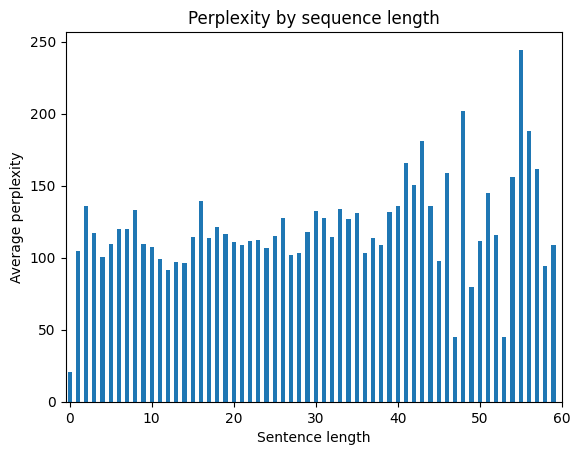

,word,target_count,target_freq,pred_count,diff,pred_freq
0,<unk>,4606,5.85%,17387,12781,22.10%
1,the,3968,5.04%,12907,8939,16.41%
2,<eos>,3761,4.78%,9355,5594,11.89%
3,N,2494,3.17%,3726,1232,4.74%
4,of,2182,2.77%,3044,862,3.87%
...,...,...,...,...,...,...
5973,external,1,0.00%,0,-1,0.00%
5974,wings,1,0.00%,0,-1,0.00%
5975,inside,1,0.00%,0,-1,0.00%
5976,instructed,1,0.00%,0,-1,0.00%


,precision,recall,f1-score,support
<eos>,0.26,0.65,0.37,3.8e+03
on,0.3,0.11,0.16,4.8e+02
<unk>,0.13,0.51,0.21,4.6e+03
N,0.56,0.69,0.62,2.5e+03
the,0.21,0.69,0.32,4e+03
$,0.41,0.41,0.41,5.4e+02
as,0.43,0.21,0.28,4.3e+02
a,0.18,0.24,0.21,1.7e+03
is,0.12,0.24,0.16,6.6e+02
of,0.35,0.6,0.44,2.2e+03


,precision,recall,f1-score,support
<eos>,0.26,0.65,0.37,3.8e+03
<unk>,0.13,0.51,0.21,4.6e+03
N,0.56,0.69,0.62,2.5e+03
are,0.1,0.21,0.14,3.6e+02
the,0.21,0.69,0.32,4e+03
$,0.41,0.41,0.41,5.4e+02
a,0.18,0.24,0.21,1.7e+03
is,0.12,0.24,0.16,6.6e+02
been,0.22,0.85,0.35,1.6e+02
of,0.35,0.6,0.44,2.2e+03


,precision,recall,f1-score,support
hutton,1.0,1.0,1.0,1e+01
kong,1.0,1.0,1.0,2.4e+01
lehman,0.91,1.0,0.95,1e+01
angeles,0.91,1.0,0.95,1e+01
lynch,0.94,0.84,0.89,1.9e+01
officer,0.81,0.94,0.87,3.6e+01
commission,0.89,0.8,0.84,2e+01
loan,1.0,0.7,0.82,2e+01
interview,0.75,0.9,0.82,1e+01
estate,0.68,1.0,0.81,1.9e+01


,precision,recall,f1-score,support
share,0.79,0.77,0.78,1.3e+02
million,0.6,0.78,0.68,3.5e+02
N,0.56,0.69,0.62,2.5e+03
president,0.64,0.41,0.5,1e+02
than,0.41,0.62,0.49,1.7e+02
year,0.4,0.63,0.49,2.1e+02
n't,0.38,0.65,0.48,3.4e+02
co.,0.49,0.43,0.46,1e+02
of,0.35,0.6,0.44,2.2e+03
inc.,0.44,0.41,0.43,1.3e+02


In [22]:
evaluate(experiment_name)

#### merity_ad_nohh_1024

In [23]:
experiment_name = "merity_ad_nohh_1024"

In [13]:
with open(f"configs/{experiment_name}.yaml") as config_file:
    config = yaml.safe_load(config_file)
print(inference(config, inf_config, "the"))

T: 1.00	=>	the surprising pace came in the july N causing paper in the u.s. effect a consumer <unk> was pegged at $ N million
T: 0.80	=>	the treasury will raise about $ N billion in short-term bills and annuities
T: 0.75	=>	the accord also includes a $ N million air force contract for power to consolidate the second-largest airline
T: 0.70	=>	the lack of <unk> money is too profitable
T: 0.50	=>	the real estate unit is n't a real estate



In [14]:
print(inference(config, inf_config, "the price"))

T: 1.00	=>	the price is at induce price
T: 0.80	=>	the price was unchanged to $ N million
T: 0.75	=>	the price of $ N a share
T: 0.70	=>	the price for the s&p N was equivalent to N N
T: 0.50	=>	the price was $ N



In [15]:
print(inference(config, inf_config, "it may"))

T: 1.00	=>	it may not always lock on european market
T: 0.80	=>	it may be far greater and more than N N of those in the stock exchange and many markets
T: 0.75	=>	it may be n't a separate <unk>
T: 0.70	=>	it may be <unk> by a <unk> plan
T: 0.50	=>	it may not be a <unk>



,inputs,targets,lengths,outputs,loss
0,"[142, 78, 54, 251, 2360, 405]","[78, 54, 251, 2360, 405, 10000]",[6],"[[-1.1988549, -1.2548482, -1.5607876, -1.18973...",5.4442177
1,"[315, 706, 32, 101, 934, 935, 936, 874, 251, 5...","[706, 32, 101, 934, 935, 936, 874, 251, 572, 5...",[37],"[[-1.500829, -1.65592, -1.2835016, -1.414056, ...",3.6605964
2,"[307, 954, 4419, 3882, 424, 32, 687, 27, 1745,...","[954, 4419, 3882, 424, 32, 687, 27, 1745, 1884...",[26],"[[-1.136029, -1.086591, -1.0284503, -1.2422093...",4.923312
3,"[32, 27, 935, 2737, 1292, 152, 32, 812, 33, 44...","[27, 935, 2737, 1292, 152, 32, 812, 33, 4402, ...",[32],"[[-1.3273237, -0.99297506, -0.9458163, -0.9323...",4.648102
4,"[812, 1623, 1375, 2569, 64, 2775, 95, 64, 32, ...","[1623, 1375, 2569, 64, 2775, 95, 64, 32, 2141,...",[24],"[[-1.2707372, -1.0347981, -1.4373713, -1.31372...",3.7722266
...,...,...,...,...,...
3756,"[853, 2574, 26, 312, 42, 32, 682, 4921, 4464, ...","[2574, 26, 312, 42, 32, 682, 4921, 4464, 504, ...",[22],"[[-0.6071999, -0.65143573, -0.29727638, -0.175...",4.5454426
3757,"[374, 2173, 380, 1287, 64, 220, 1729, 2083]","[2173, 380, 1287, 64, 220, 1729, 2083, 10000]",[8],"[[-0.68605363, -0.8292419, -0.30017054, -0.206...",5.2046256
3758,"[160, 710, 2378, 119, 3302, 374, 1134, 152, 55...","[710, 2378, 119, 3302, 374, 1134, 152, 556, 26...",[20],"[[-1.0581164, -1.2457604, -0.9231479, -0.82422...",5.3370314
3759,"[130, 26, 7649, 373, 130, 2573, 93, 32, 499, 4...","[26, 7649, 373, 130, 2573, 93, 32, 499, 40, 17...",[24],"[[-0.8072857, -1.0000955, -0.57780445, -0.4472...",4.3449206


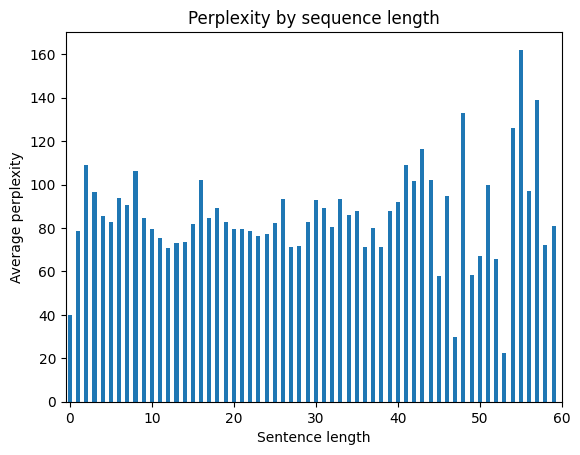

,word,target_count,target_freq,pred_count,diff,pred_freq
0,<unk>,4606,5.85%,16365,11759,20.80%
1,the,3968,5.04%,12146,8178,15.44%
2,<eos>,3761,4.78%,8679,4918,11.03%
3,N,2494,3.17%,3894,1400,4.95%
4,of,2182,2.77%,3034,852,3.86%
...,...,...,...,...,...,...
5973,external,1,0.00%,0,-1,0.00%
5974,wings,1,0.00%,0,-1,0.00%
5975,inside,1,0.00%,0,-1,0.00%
5976,instructed,1,0.00%,0,-1,0.00%


,precision,recall,f1-score,support
<eos>,0.29,0.67,0.41,3.8e+03
on,0.36,0.15,0.21,4.8e+02
<unk>,0.15,0.52,0.23,4.6e+03
N,0.57,0.7,0.63,2.5e+03
the,0.23,0.7,0.34,4e+03
$,0.36,0.55,0.44,5.4e+02
as,0.48,0.23,0.31,4.3e+02
a,0.22,0.24,0.23,1.7e+03
is,0.14,0.29,0.19,6.6e+02
of,0.36,0.63,0.46,2.2e+03


,precision,recall,f1-score,support
<eos>,0.29,0.67,0.41,3.8e+03
<unk>,0.15,0.52,0.23,4.6e+03
N,0.57,0.7,0.63,2.5e+03
are,0.14,0.35,0.2,3.6e+02
the,0.23,0.7,0.34,4e+03
$,0.36,0.55,0.44,5.4e+02
a,0.22,0.24,0.23,1.7e+03
is,0.14,0.29,0.19,6.6e+02
been,0.21,0.9,0.34,1.6e+02
of,0.36,0.63,0.46,2.2e+03


,precision,recall,f1-score,support
hutton,1.0,1.0,1.0,1e+01
kong,1.0,1.0,1.0,2.4e+01
lehman,0.91,1.0,0.95,1e+01
angeles,0.91,1.0,0.95,1e+01
lynch,0.94,0.84,0.89,1.9e+01
officer,0.77,0.94,0.85,3.6e+01
commission,0.94,0.75,0.83,2e+01
loan,0.94,0.75,0.83,2e+01
cents,0.81,0.78,0.8,7.3e+01
share,0.79,0.78,0.79,1.3e+02


,precision,recall,f1-score,support
share,0.79,0.78,0.79,1.3e+02
million,0.62,0.76,0.68,3.5e+02
N,0.57,0.7,0.63,2.5e+03
co.,0.49,0.59,0.53,1e+02
year,0.46,0.59,0.52,2.1e+02
than,0.43,0.64,0.52,1.7e+02
n't,0.44,0.61,0.51,3.4e+02
billion,0.59,0.42,0.49,1.3e+02
president,0.56,0.43,0.49,1e+02
&,0.41,0.56,0.47,1.2e+02


In [25]:
evaluate(experiment_name)

#### merity_ad_nohh_1024_ps_long

In [26]:
experiment_name = "merity_ad_nohh_1024_ps_long"

In [27]:
with open(f"configs/{experiment_name}.yaml") as config_file:
    config = yaml.safe_load(config_file)
print(inference(config, inf_config, "the"))

T: 1.00	=>	the major <unk> million foreign equipment received a $ N million offer for federated and packaged goods companies
T: 0.80	=>	the very least some successes will not be a <unk> for children
T: 0.75	=>	the atlanta-based company said it would n't cut its fourth-quarter dividend to $ N a share
T: 0.70	=>	the latest period included a $ N million charge related to the sale of the company 's <unk> division
T: 0.50	=>	the company said it will sell its N N stake in the company to N N



In [28]:
print(inference(config, inf_config, "the price"))

T: 1.00	=>	the price advanced increase in the second quarter in workstations prompting the dollar to a steep rise in the week 's sharp climb in the imports growth of the
T: 0.80	=>	the price for the giant company is about $ N million
T: 0.75	=>	the price for the dow jones industrial average climbed N points to N
T: 0.70	=>	the price value of the bonds fell a total after a special dividend of N cents a share from the previous sale of a $ N cumulative convertible preferred
T: 0.50	=>	the price of the N N stock price index has grown N N



In [29]:
print(inference(config, inf_config, "it may"))

T: 1.00	=>	it may pose a novel to the <unk> of anything named and mr. lang also mr. douglas
T: 0.80	=>	it may be able to make a special new management bill for an management situation
T: 0.75	=>	it may be of the pursuit of the <unk> and <unk> by all this <unk> <unk> may be <unk> and <unk>
T: 0.70	=>	it may be <unk> while the <unk> <unk>
T: 0.50	=>	it may be a <unk>



,inputs,targets,lengths,outputs,loss
0,"[142, 78, 54, 251, 2360, 405]","[78, 54, 251, 2360, 405, 10000]",[6],"[[-1.3540521, -1.5436362, -1.3431797, -1.87521...",5.374517
1,"[315, 706, 32, 101, 934, 935, 936, 874, 251, 5...","[706, 32, 101, 934, 935, 936, 874, 251, 572, 5...",[37],"[[-1.4399024, -1.6407709, -1.8681731, -1.62360...",3.7358499
2,"[307, 954, 4419, 3882, 424, 32, 687, 27, 1745,...","[954, 4419, 3882, 424, 32, 687, 27, 1745, 1884...",[26],"[[-1.3111296, -1.2712903, -1.2113384, -1.52839...",4.992341
3,"[32, 27, 935, 2737, 1292, 152, 32, 812, 33, 44...","[27, 935, 2737, 1292, 152, 32, 812, 33, 4402, ...",[32],"[[-1.538535, -1.3653407, -0.6060799, -0.945456...",4.53283
4,"[812, 1623, 1375, 2569, 64, 2775, 95, 64, 32, ...","[1623, 1375, 2569, 64, 2775, 95, 64, 32, 2141,...",[24],"[[-1.0163815, -1.1206521, -2.1486754, -2.32614...",3.8640804
...,...,...,...,...,...
3756,"[853, 2574, 26, 312, 42, 32, 682, 4921, 4464, ...","[2574, 26, 312, 42, 32, 682, 4921, 4464, 504, ...",[22],"[[-0.4543704, -0.84683543, -0.74553424, -0.260...",4.3878765
3757,"[374, 2173, 380, 1287, 64, 220, 1729, 2083]","[2173, 380, 1287, 64, 220, 1729, 2083, 10000]",[8],"[[-1.2191556, -1.1798574, 0.06317608, -0.45934...",4.9303174
3758,"[160, 710, 2378, 119, 3302, 374, 1134, 152, 55...","[710, 2378, 119, 3302, 374, 1134, 152, 556, 26...",[20],"[[-0.7946488, -1.2890111, -1.0032957, -0.79609...",5.270899
3759,"[130, 26, 7649, 373, 130, 2573, 93, 32, 499, 4...","[26, 7649, 373, 130, 2573, 93, 32, 499, 40, 17...",[24],"[[-1.4316986, -1.7362494, -0.6040301, -0.98304...",4.405933


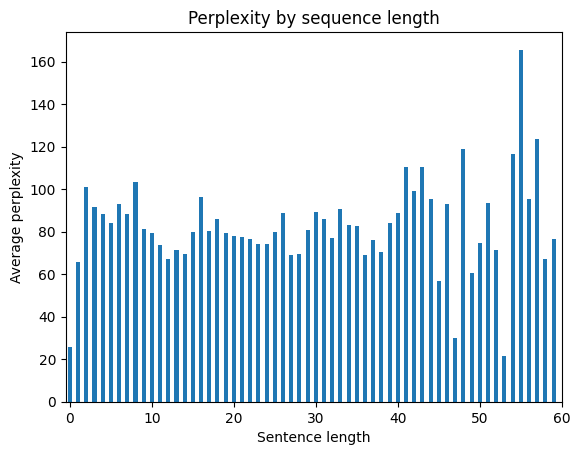

,word,target_count,target_freq,pred_count,diff,pred_freq
0,<unk>,4606,5.85%,15026,10420,19.10%
1,the,3968,5.04%,12405,8437,15.77%
2,<eos>,3761,4.78%,9125,5364,11.60%
3,N,2494,3.17%,3874,1380,4.92%
4,of,2182,2.77%,3236,1054,4.11%
...,...,...,...,...,...,...
5973,external,1,0.00%,0,-1,0.00%
5974,wings,1,0.00%,0,-1,0.00%
5975,inside,1,0.00%,0,-1,0.00%
5976,instructed,1,0.00%,0,-1,0.00%


,precision,recall,f1-score,support
<eos>,0.28,0.69,0.4,3.8e+03
on,0.33,0.16,0.22,4.8e+02
<unk>,0.15,0.49,0.23,4.6e+03
N,0.55,0.71,0.62,2.5e+03
the,0.22,0.7,0.34,4e+03
$,0.42,0.5,0.45,5.4e+02
as,0.47,0.23,0.31,4.3e+02
a,0.2,0.27,0.23,1.7e+03
is,0.14,0.23,0.17,6.6e+02
of,0.36,0.64,0.46,2.2e+03


,precision,recall,f1-score,support
<eos>,0.28,0.69,0.4,3.8e+03
<unk>,0.15,0.49,0.23,4.6e+03
N,0.55,0.71,0.62,2.5e+03
are,0.14,0.35,0.2,3.6e+02
the,0.22,0.7,0.34,4e+03
$,0.42,0.5,0.45,5.4e+02
a,0.2,0.27,0.23,1.7e+03
is,0.14,0.23,0.17,6.6e+02
been,0.22,0.87,0.35,1.6e+02
of,0.36,0.64,0.46,2.2e+03


,precision,recall,f1-score,support
hutton,1.0,1.0,1.0,1e+01
kong,1.0,1.0,1.0,2.4e+01
lehman,0.91,1.0,0.95,1e+01
angeles,0.91,1.0,0.95,1e+01
lynch,0.94,0.84,0.89,1.9e+01
officer,0.76,0.94,0.84,3.6e+01
share,0.81,0.78,0.8,1.3e+02
estate,0.66,1.0,0.79,1.9e+01
loan,0.83,0.75,0.79,2e+01
cents,0.88,0.7,0.78,7.3e+01


,precision,recall,f1-score,support
share,0.81,0.78,0.8,1.3e+02
million,0.6,0.8,0.68,3.5e+02
N,0.55,0.71,0.62,2.5e+03
than,0.46,0.68,0.55,1.7e+02
co.,0.48,0.61,0.54,1e+02
billion,0.71,0.4,0.51,1.3e+02
year,0.42,0.65,0.51,2.1e+02
president,0.67,0.41,0.51,1e+02
n't,0.39,0.65,0.49,3.4e+02
of,0.36,0.64,0.46,2.2e+03


In [30]:
evaluate(experiment_name)